In [1]:
import pickle
import torch
from matplotlib import pyplot as plt
import numpy as np

with open("results2022", "rb") as file:
    logits, labels, ids, files = pickle.load(file)



for f in ["results2021_1", "results2021_2", "results2021_3", "results2021_4"]:
    with open(f, "rb") as file:
        logits_, labels_, ids_, files_ = pickle.load(file)
        logits = torch.cat((logits, logits_))
        labels = torch.cat((labels, labels_))
        ids = ids + ids_
        files = files + files_




a = np.argsort(ids)
logits = logits[a]
labels = labels[a]
ids = np.array(ids)[a]
files = np.array(files)[a]



# %matplotlib inline

# plt.hist(logits[:,1])



In [2]:
import jsonlines
import os
from tqdm import tqdm, trange
files = os.listdir("../articles")


texts = list()
uri = list()

filenames = list()

for file in tqdm(files):
    with jsonlines.open(os.path.join("../articles", file)) as f:
        for line in f.iter():
            uri.append(line["uri"]) 
            texts.append(line["body"])
            filenames.append(file)


a = np.argsort(uri)
texts = [texts[i] for i in a]
uri = np.array(uri)[a]
filenames = np.array(filenames)[a]



 11%|█▏        | 63/550 [00:23<02:58,  2.73it/s]


KeyboardInterrupt: 

In [3]:
import datasets
from transformers import AutoTokenizer
data = datasets.Dataset.from_dict({"id":uri, "input":texts, "files":filenames, "logits":logits, "labels":labels})

CACHE_DIR = "D:/huggingface/"
CHECKPOINT_NAME =  "meta-llama/Meta-Llama-3-8B"

tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_NAME, cache_dir=CACHE_DIR)

def preprocess(x):
    return {"length":len(tokenizer(x["input"])["input_ids"])}


data = data.map(preprocess)


with open("temp_results", "wb") as file:
    pickle.dump(data[:], file)

# input_ids = data[:]["input_ids"]
# from multiprocessing import Pool

# with Pool(16) as p:
#     lenghts = p.map(lambda x: len(x), input_ids)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1106075 [00:00<?, ? examples/s]

In [1]:
import datasets
import pickle
import torch
from matplotlib import pyplot as plt
import numpy as np

with open("temp_results", "rb") as file:
    data = pickle.load(file)

data = datasets.Dataset.from_dict(data)
data = data.filter(lambda x: x["length"]<1025)

Filter:   0%|          | 0/1106075 [00:00<?, ? examples/s]

In [2]:
data = data.remove_columns(["logits", "labels", "length"])

import datasets
from transformers import AutoTokenizer

CACHE_DIR = "D:/huggingface/"
CHECKPOINT_NAME =  "meta-llama/Meta-Llama-3-8B"

tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_NAME, cache_dir=CACHE_DIR)

def tokenize(x):
    return tokenizer(x["input"], padding="max_length", max_length=1024)
tokenizer.pad_token = tokenizer.eos_token


data = data.map(tokenize, batched=True)
data = data.remove_columns(["input"])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/905634 [00:00<?, ? examples/s]

In [3]:
part = len(data)//4
for i in range(4):
    with open(f"articles_part{i}", "wb") as file:
        pickle.dump(data[i*part:(i+1)*part], file)




(array([ 46953.,  28892.,  25672.,  24785.,  25339.,  27308.,  32331.,
         41966.,  69342., 583046.]),
 array([3.69548798e-06, 9.99755859e-02, 1.99951172e-01, 3.00048828e-01,
        3.99902344e-01, 5.00000000e-01, 6.00097656e-01, 7.00195312e-01,
        7.99804688e-01, 8.99902344e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

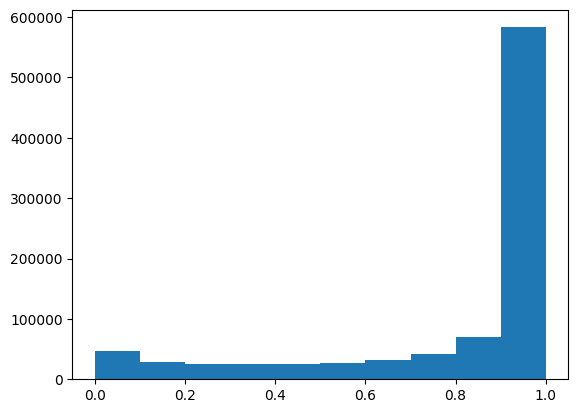

In [11]:
import torch
l = torch.tensor(data["logits"])

%matplotlib inline
plt.hist(l[:,1])

In [2]:
texts = data[:]["input"]


In [6]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer


model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2").cuda()
#model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2").cuda()
vectorizer = CountVectorizer(stop_words=["še", "ter", "zato", "namreč", "tem", "niso", "zaradi", "a","ali","april","avgust","b","bi","bil","bila","bile","bili","bilo","biti","blizu","bo","bodo","bojo","bolj","bom","bomo","boste","bova","boš","brez","c","cel","cela","celi","celo","d","da","daleč","dan","danes","datum","december","deset","deseta","deseti","deseto","devet","deveta","deveti","deveto","do","dober","dobra","dobri","dobro","dokler","dol","dolg","dolga","dolgi","dovolj","drug","druga","drugi","drugo","dva","dve","e","eden","en","ena","ene","eni","enkrat","eno","etc.","f","februar","g","g.","ga","ga.","gor","gospa","gospod","h","halo","i","idr.","ii","iii","in","iv","ix","iz","j","januar","jaz","je","ji","jih","jim","jo","julij","junij","jutri","k","kadarkoli","kaj","kajti","kako","kakor","kamor","kamorkoli","kar","karkoli","katerikoli","kdaj","kdo","kdorkoli","ker","ki","kje","kjer","kjerkoli","ko","koder","koderkoli","koga","komu","kot","kratek","kratka","kratke","kratki","l","lahka","lahke","lahki","lahko","le","lep","lepa","lepe","lepi","lepo","leto","m","maj","majhen","majhna","majhni","malce","malo","manj","marec","me","med","medtem","mene","mesec","mi","midva","midve","mnogo","moj","moja","moje","mora","morajo","moram","moramo","morate","moraš","morem","mu","n","na","nad","naj","najina","najino","najmanj","naju","največ","nam","narobe","nas","nato","nazaj","naš","naša","naše","ne","nedavno","nedelja","nek","neka","nekaj","nekatere","nekateri","nekatero","nekdo","neke","nekega","neki","nekje","neko","nekoga","nekoč","ni","nikamor","nikdar","nikjer","nikoli","nič","nje","njega","njegov","njegova","njegovo","njej","njemu","njen","njena","njeno","nji","njih","njihov","njihova","njihovo","njiju","njim","njo","njun","njuna","njuno","no","nocoj","november","npr.","o","ob","oba","obe","oboje","od","odprt","odprta","odprti","okoli","oktober","on","onadva","one","oni","onidve","osem","osma","osmi","osmo","oz.","p","pa","pet","peta","petek","peti","peto","po","pod","pogosto","poleg","poln","polna","polni","polno","ponavadi","ponedeljek","ponovno","potem","povsod","pozdravljen","pozdravljeni","prav","prava","prave","pravi","pravo","prazen","prazna","prazno","prbl.","precej","pred","prej","preko","pri","pribl.","približno","primer","pripravljen","pripravljena","pripravljeni","proti","prva","prvi","prvo","r","ravno","redko","res","reč","s","saj","sam","sama","same","sami","samo","se","sebe","sebi","sedaj","sedem","sedma","sedmi","sedmo","sem","september","seveda","si","sicer","skoraj","skozi","slab","smo","so","sobota","spet","sreda","srednja","srednji","sta","ste","stran","stvar","sva","t","ta","tak","taka","take","taki","tako","takoj","tam","te","tebe","tebi","tega","težak","težka","težki","težko","ti","tista","tiste","tisti","tisto","tj.","tja","to","toda","torek","tretja","tretje","tretji","tri","tu","tudi","tukaj","tvoj","tvoja","tvoje","u","v","vaju","vam","vas","vaš","vaša","vaše","ve","vedno","velik","velika","veliki","veliko","vendar","ves","več","vi","vidva","vii","viii","visok","visoka","visoke","visoki","vsa","vsaj","vsak","vsaka","vsakdo","vsake","vsaki","vsakomur","vse","vsega","vsi","vso","včasih","včeraj","x","z","za","zadaj","zadnji","zakaj","zaprta","zaprti","zaprto","zdaj","zelo","zunaj","č","če","često","četrta","četrtek","četrti","četrto","čez","čigav","š","šest","šesta","šesti","šesto","štiri","ž","že"])
from bertopic.vectorizers import ClassTfidfTransformer

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

topic_model = BERTopic(embedding_model=model, ctfidf_model=ctfidf_model, calculate_probabilities=False, top_n_words=10, min_topic_size=200, nr_topics=10, vectorizer_model=vectorizer)
topics, probs = topic_model.fit_transform(texts)

with open("topics_model_results", "wb") as file:
    pickle.dump((model, topic_model, topics, probs), file)


topic_model.get_topics()



: 

: 

: 

In [1]:
import datasets
import pickle
import torch
from matplotlib import pyplot as plt
import numpy as np


from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer




with open("topics_model_results2", "rb") as file:
    model_, topic_model_, topics_, probs_ = pickle.load(file)

TypeError: code expected at most 16 arguments, got 18

(array([62617., 18588.,  8165.,  2608.,  1705.,  3045.,  1099.,  1193.,
          431.,   549.]),
 array([-1. ,  0.4,  1.8,  3.2,  4.6,  6. ,  7.4,  8.8, 10.2, 11.6, 13. ]),
 <BarContainer object of 10 artists>)

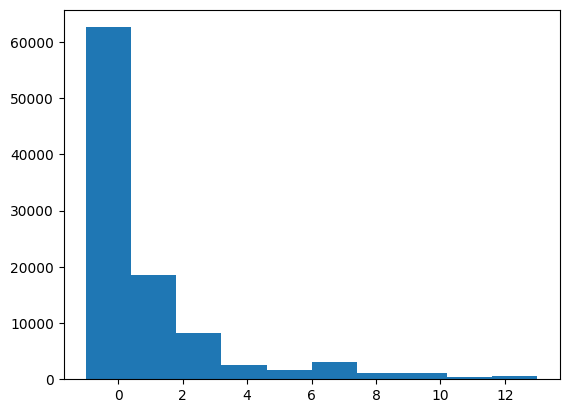

In [27]:
%matplotlib inline

plt.hist(topics)

([0,
  0,
  -1,
  -1,
  -1,
  1,
  -1,
  0,
  0,
  -1,
  -1,
  0,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  1,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  -1,
  0,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  1,
  -1,
  0,
  1,
  1,
  0,
  0,
  -1,
  0,
  0,
  -1,
  -1,
  -1,
  0,
  -1,
  0,
  0,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  -1,
  1,
  0,
  -1,
  -1,
  0,
  -1,
  0,
  0,
  -1,
  -1,
  0,
  0,
  0,
  -1,
  0,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  0,
  -1,
  0,
  -1,
  0,
  0,
  0,
  0,
  -1,
  0,
  -1,
  -1,
  -1,
  0,
  -1,
  1,
  -1,
  1,
  -1,
  -1,
  0,
  -1,
  1,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  -1,
  -1,
  0,
  -1,
  -1,
  0,
  -1,
  1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  0,
  0,
  -1,
  -1,
  1,
  0,
  0,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  -1,
  -1,


In [11]:
CACHE_DIR = "D:/huggingface/"
CHECKPOINT_NAME =  "embeddia/sloberta"
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_NAME, cache_dir=CACHE_DIR)

def preprocess(x):
    return {"length2":len(tokenizer(x["input"], max_length=1024, truncation=True)["input_ids"])}


data = data.map(preprocess)

data = data.filter(lambda x: x["length2"]<513)


Map:   0%|          | 0/905634 [00:00<?, ? examples/s]

Filter:   0%|          | 0/905634 [00:00<?, ? examples/s]

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
CACHE_DIR = "D:/huggingface/"
TRAINERS_DIR = "D:/trainers/"
FINAL_MODELS_DIR = "D:/models/"
MODEL_NAME = "sloberta-sarcasm"
CHECKPOINT_NAME = "embeddia/sloberta"





model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=os.path.join(FINAL_MODELS_DIR, MODEL_NAME), cache_dir=CACHE_DIR)
from transformers import Trainer, TrainingArguments
import datasets
args = TrainingArguments(output_dir=os.path.join(TRAINERS_DIR, MODEL_NAME), logging_strategy="steps", logging_steps=1)#, eval_accumulation_steps=32)


trainer = Trainer(model=model, args=args,)

import torch
MAX_LENGTH=512


def preprocess(x):
    return tokenizer(x["input"], max_length=MAX_LENGTH, truncation=True, padding="max_length")

tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_NAME, cache_dir=CACHE_DIR)


data = data.map(preprocess, batched=True, batch_size=1000)
#data = data.select_columns(['input_ids', 'attention_mask'])

preds = trainer.predict(test_dataset=data)

    

Map:   0%|          | 0/842963 [00:00<?, ? examples/s]

  0%|          | 0/105371 [00:00<?, ?it/s]

In [17]:
with open("results-sloberta", "wb") as file:
    pickle.dump((preds.predictions, data[:]["id"]), file)

In [30]:
with open("results-sloberta", "rb") as file:
    preds, ids = pickle.load(file)
%matplotlib inline
plt.hist(torch.softmax(torch.tensor(preds), dim=1)[:,1])

In [1]:
import pickle
import torch
from matplotlib import pyplot as plt
import numpy as np
import datasets
from tqdm import trange
import os

ids, probs, labels, files = list(), list(), list(), list()
for f in ["finalresults_part0", "finalresults_part1", "finalresults_part2", "finalresults_part3"]:
    with open(f, "rb") as file:
        results = pickle.load(file)
        ids += results["id"]
        probs += list(results["probs"].numpy())
        labels += list(results["labels"].numpy())
        files += results["files"]







In [3]:
plt.rcParams['figure.dpi'] = 2000
%matplotlib inline

plt.hist(np.array(probs)[:,1], bins=100)
plt.xlabel("Napovedana verjetnost sarkazma")
plt.ylabel("Število primerov")
plt.title("Distribucija napovedi prilagojenega modela Llama 3 na množici EventRegistry")
plt.savefig("result_total.pdf")

sum(labels)/len(labels), sum(labels)

(0.03578605879650896, 32409)

In [3]:
DATA_DIR = "D:/mag_data/topic_results_final/"
FILE = "minilm-1500-10-10"

with open(os.path.join(DATA_DIR, FILE), "rb") as file:
    data, topics_map, topics_dist = pickle.load(file)

data = datasets.Dataset.from_dict(data[:len(ids)])
data = data.add_column(name="prob", column=np.array(probs)[:,1]) # type: ignore
data = data.add_column(name="label", column=np.array(labels))


probs_by_topic = list()
datasets.disable_progress_bar()

for i in trange(1+max(data["topic"])):
    probs_by_topic.append(data.filter(lambda x: x["topic"] == (i-1)))

datasets.enable_progress_bar()


percentage_sarcasm = list()
topic_words = list()
for i, d in enumerate(probs_by_topic):
    percentage_sarcasm.append(np.round(100*np.sum(d["label"])/len(d["label"]), 2))
    topic_words.append(" ".join([w for w, _ in topics_map[i-1]]))

s = np.argsort(percentage_sarcasm)[::-1]

percentage_sarcasm = np.array(percentage_sarcasm)[s]
topic_words = np.array(topic_words)[s]

probs_by_topic = list(np.array(probs_by_topic, dtype=object)[s])


100%|██████████| 50/50 [02:39<00:00,  3.19s/it]


In [6]:
with open('results_final_sorted', 'wb') as file:
    pickle.dump(probs_by_topic, file)

In [ ]:
import pickle
with open('results_final_sorted', 'rb') as file:
    r = pickle.load(file)

r = [set(r_.filter(lambda x: x['label']).shuffle(seed=42).select(range(50)).sort('id')['id']) for r_ in r[:5]]

with open('sample', 'wb') as file:
    pickle.dump(r, file)

100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


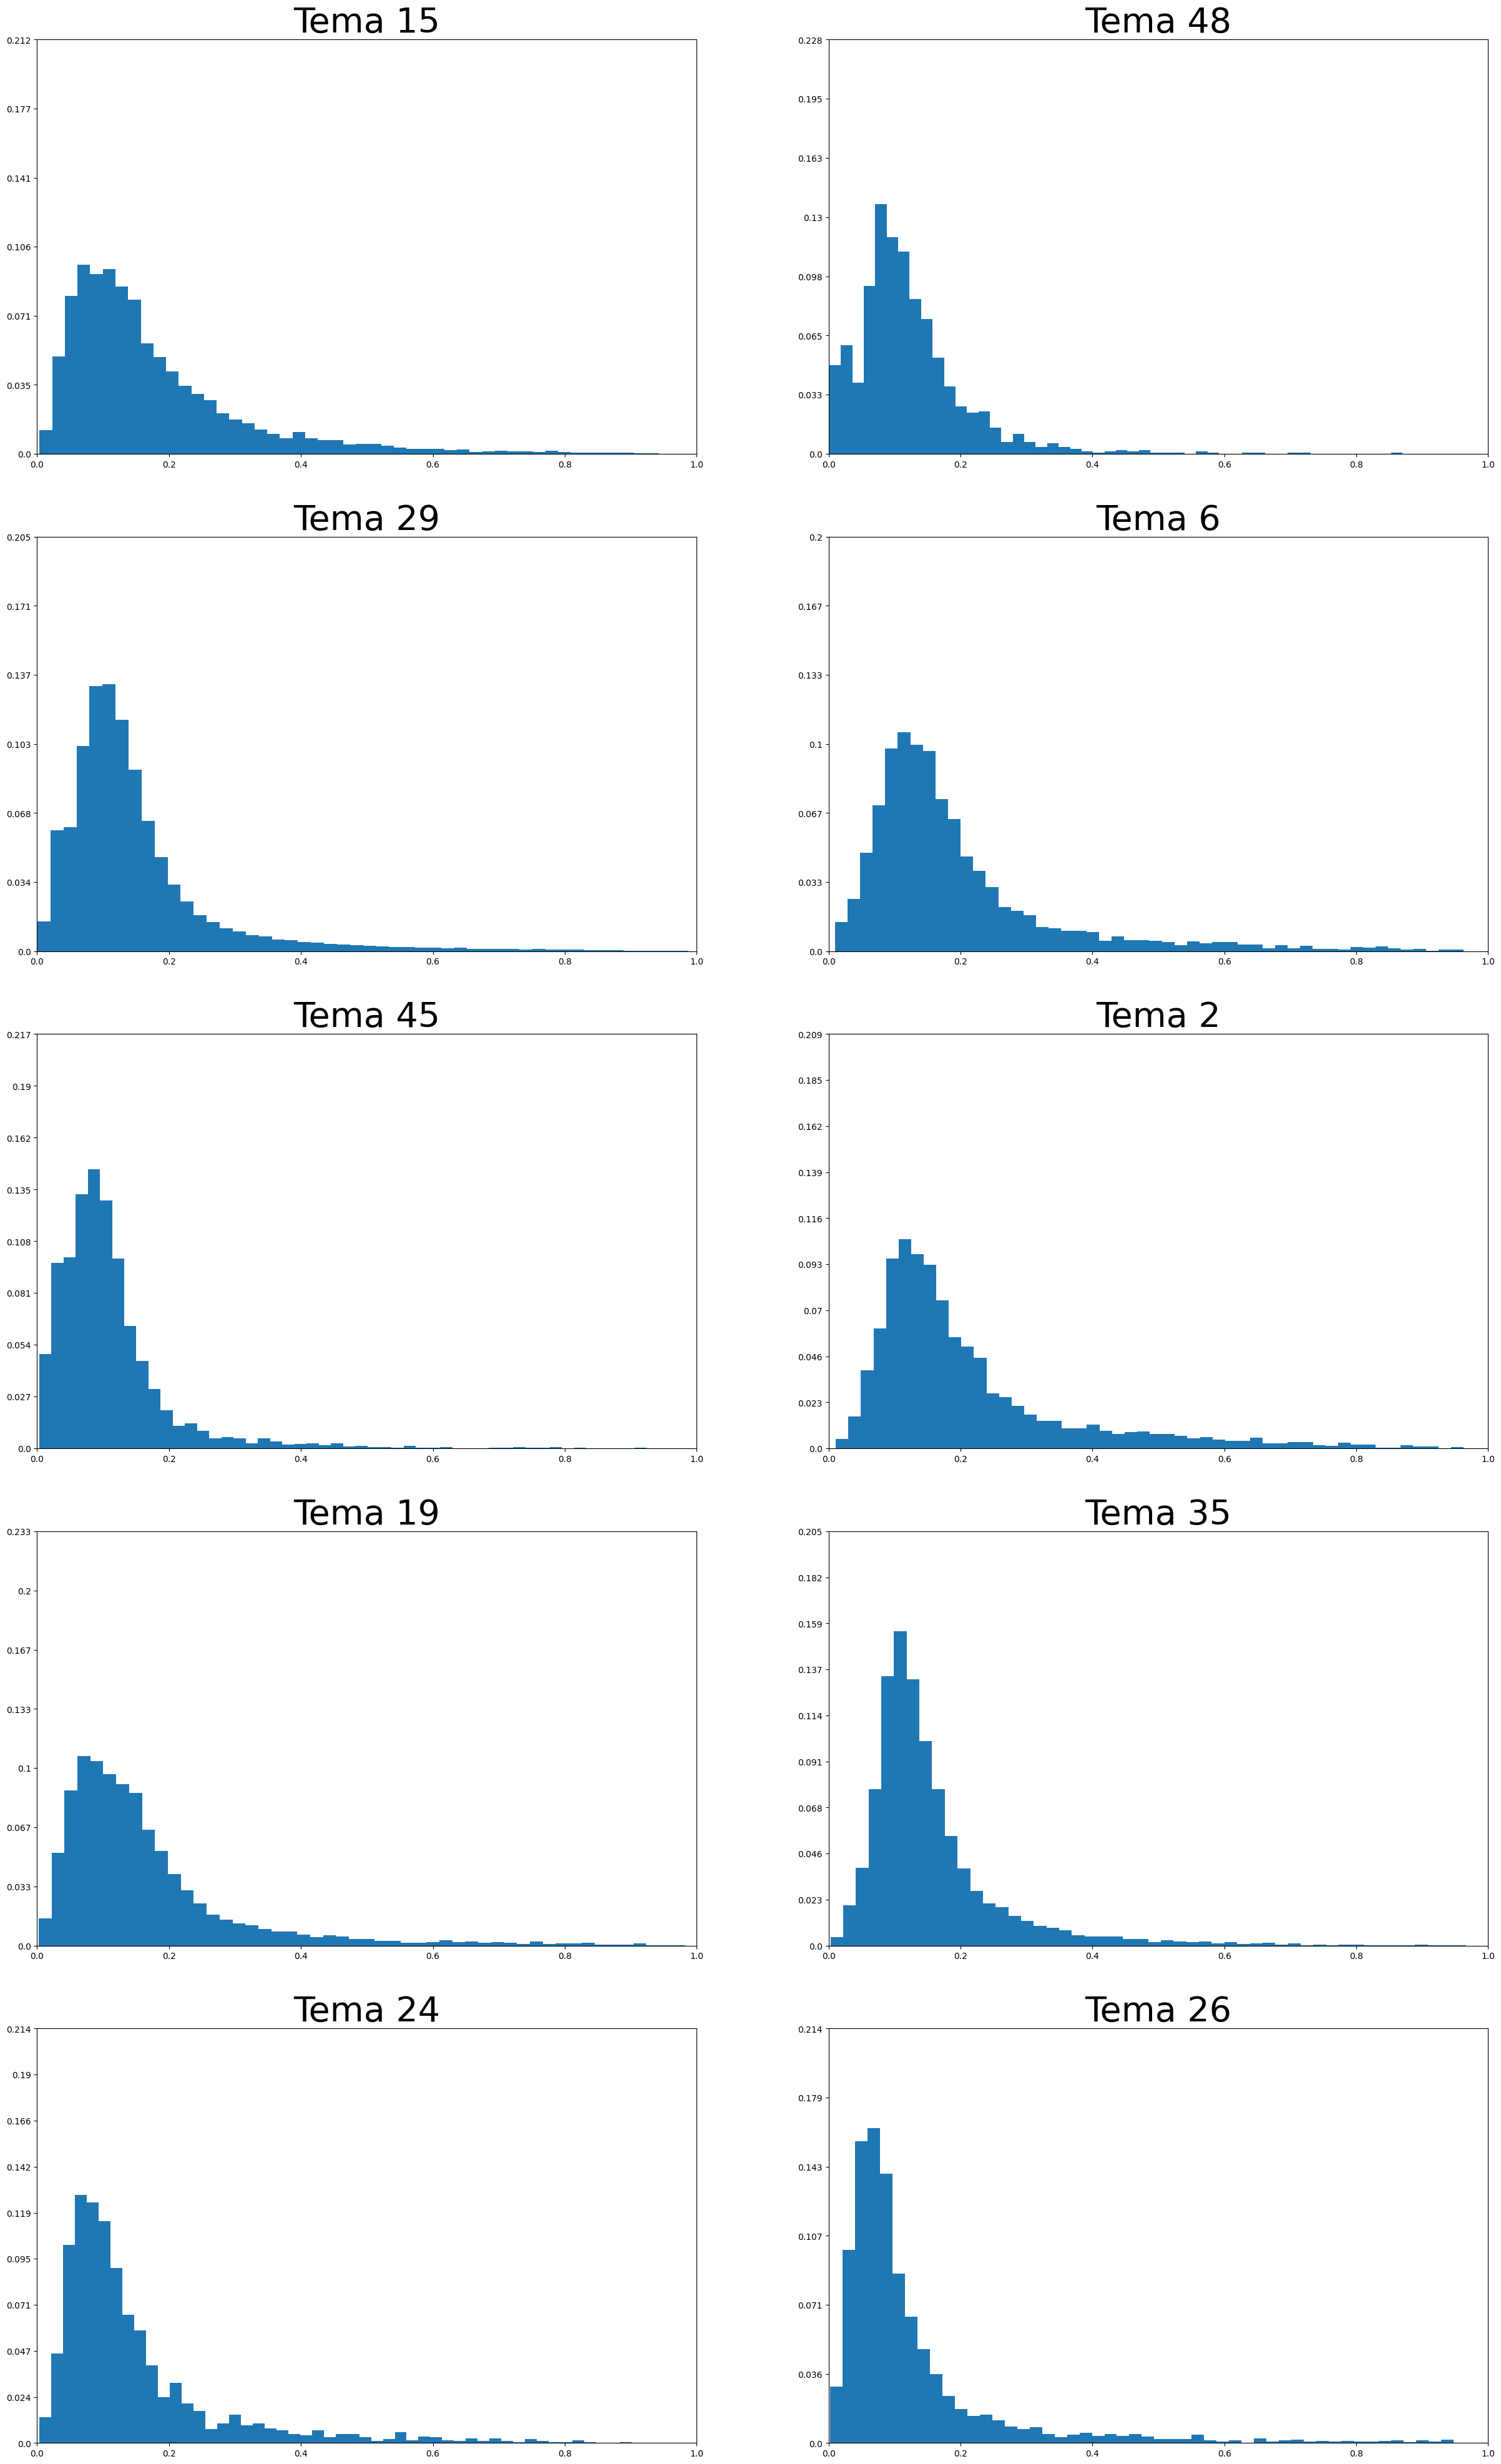

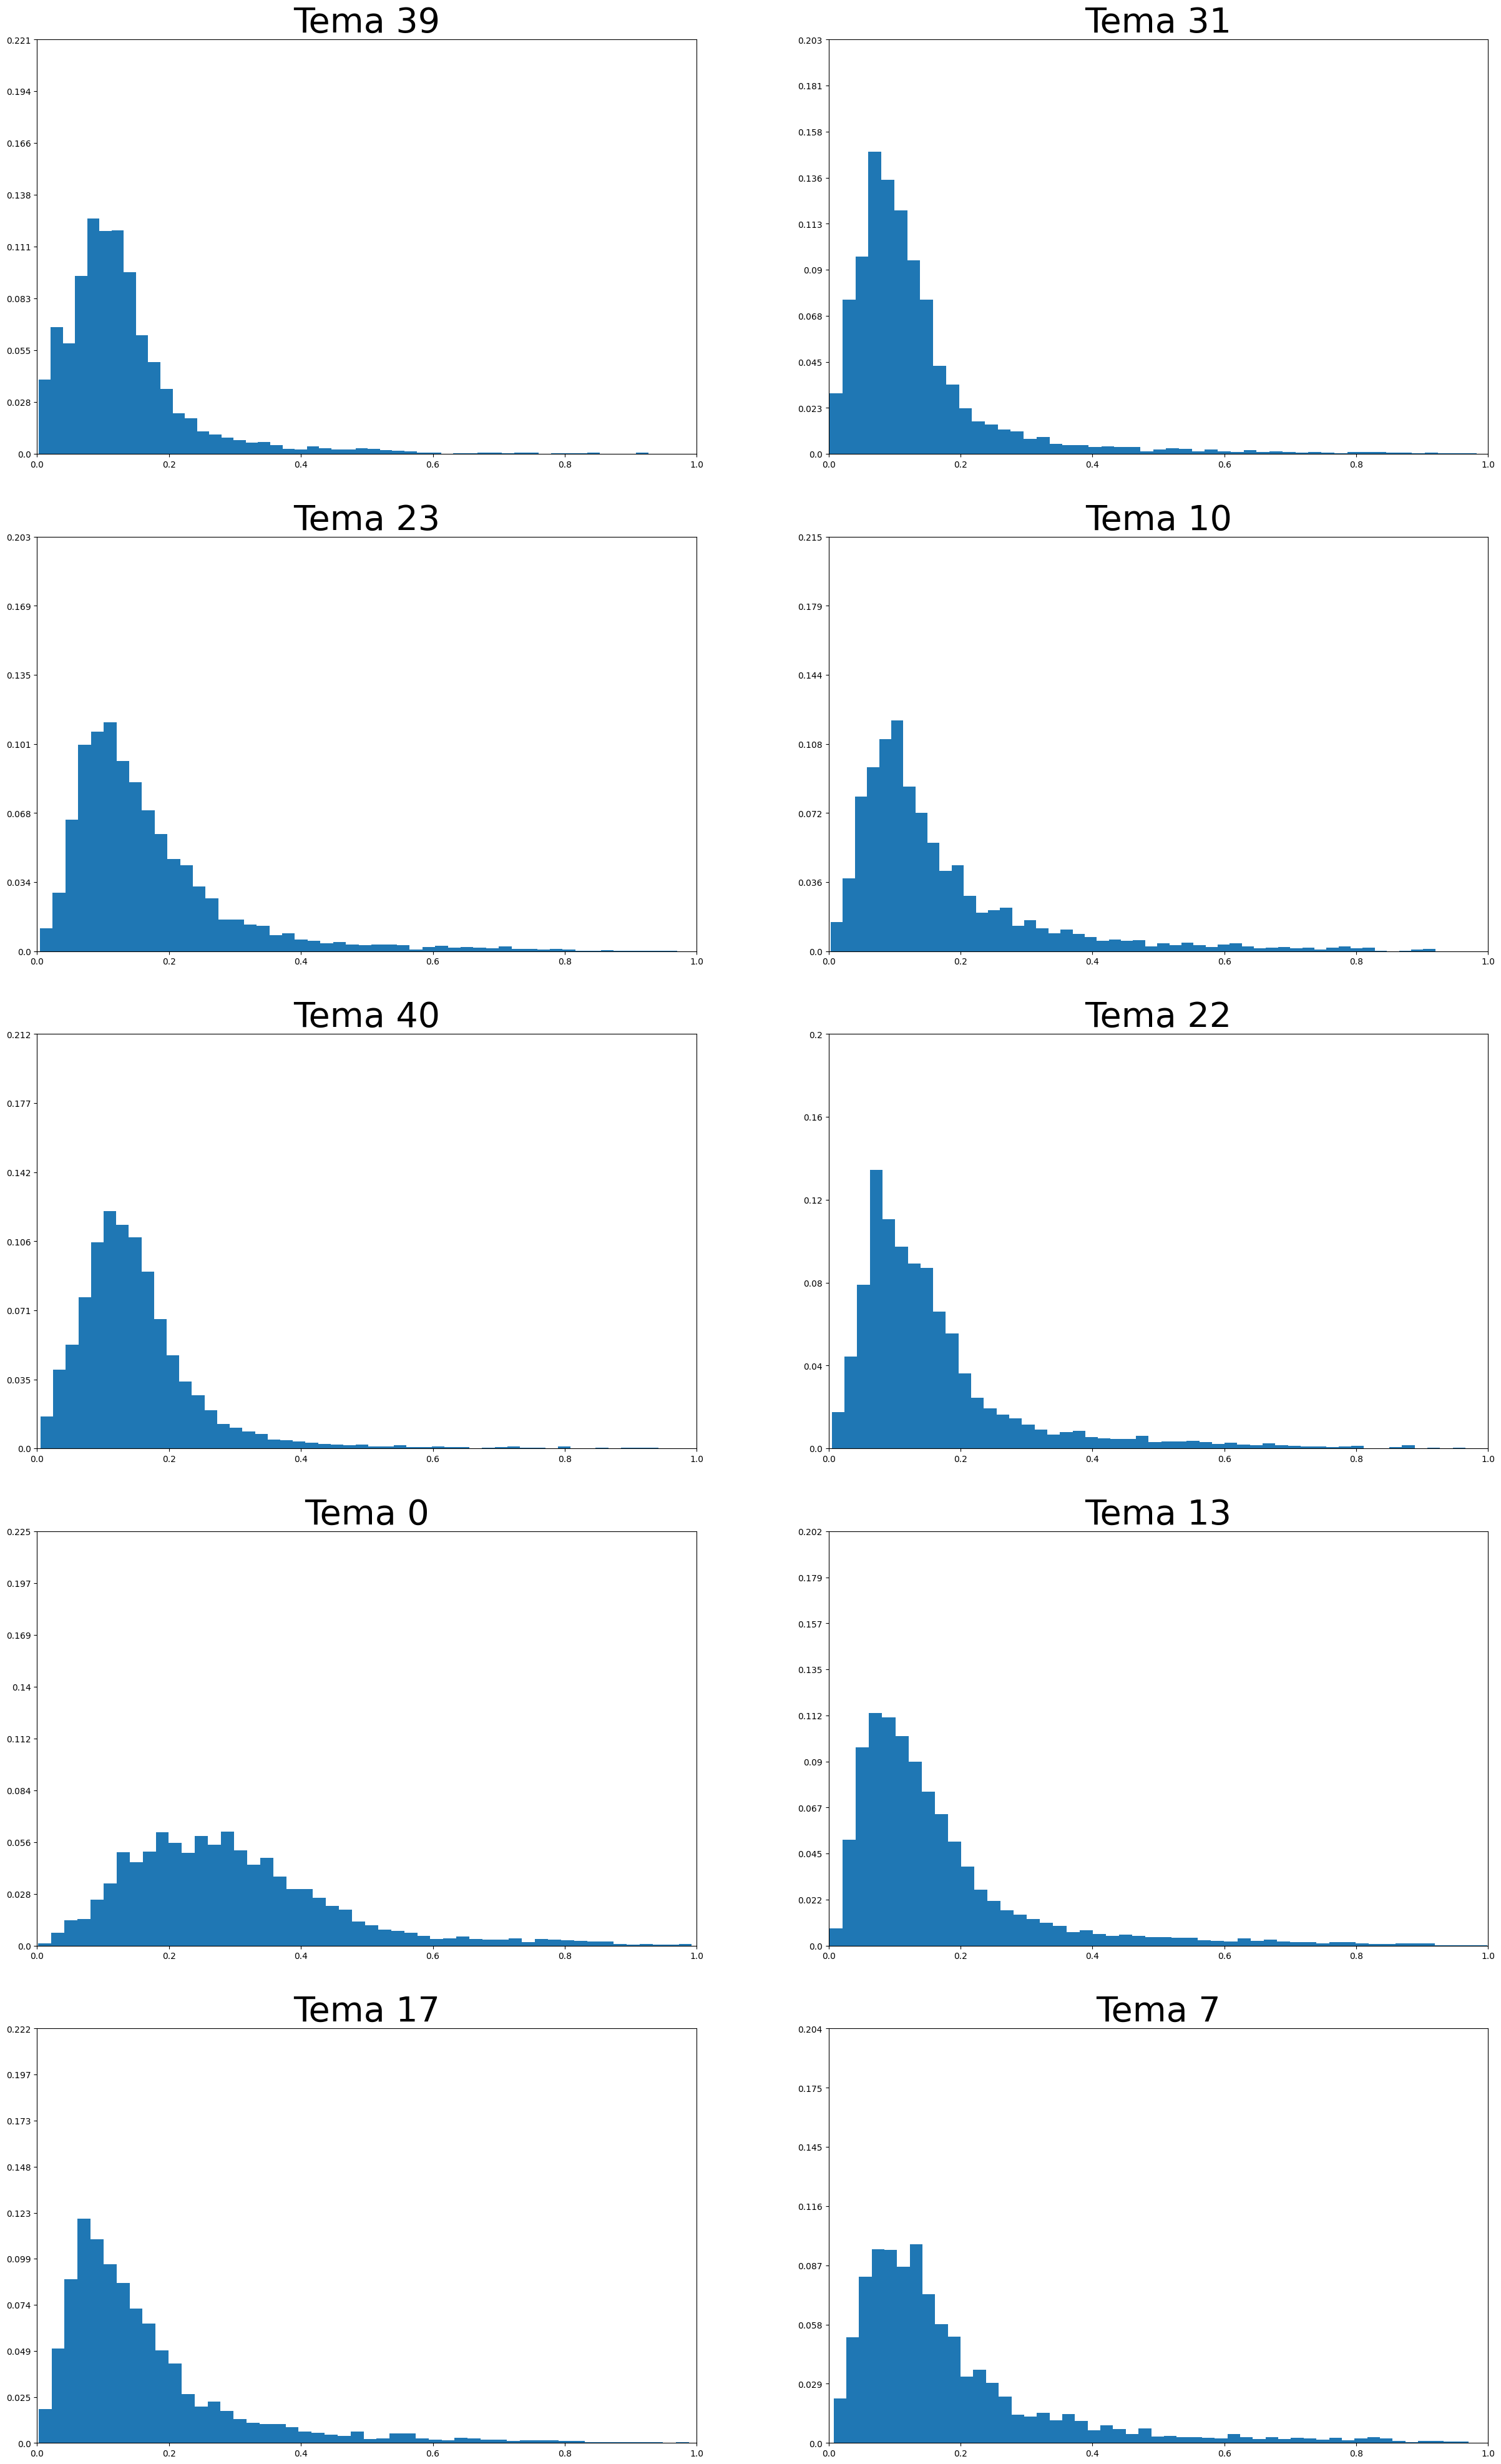

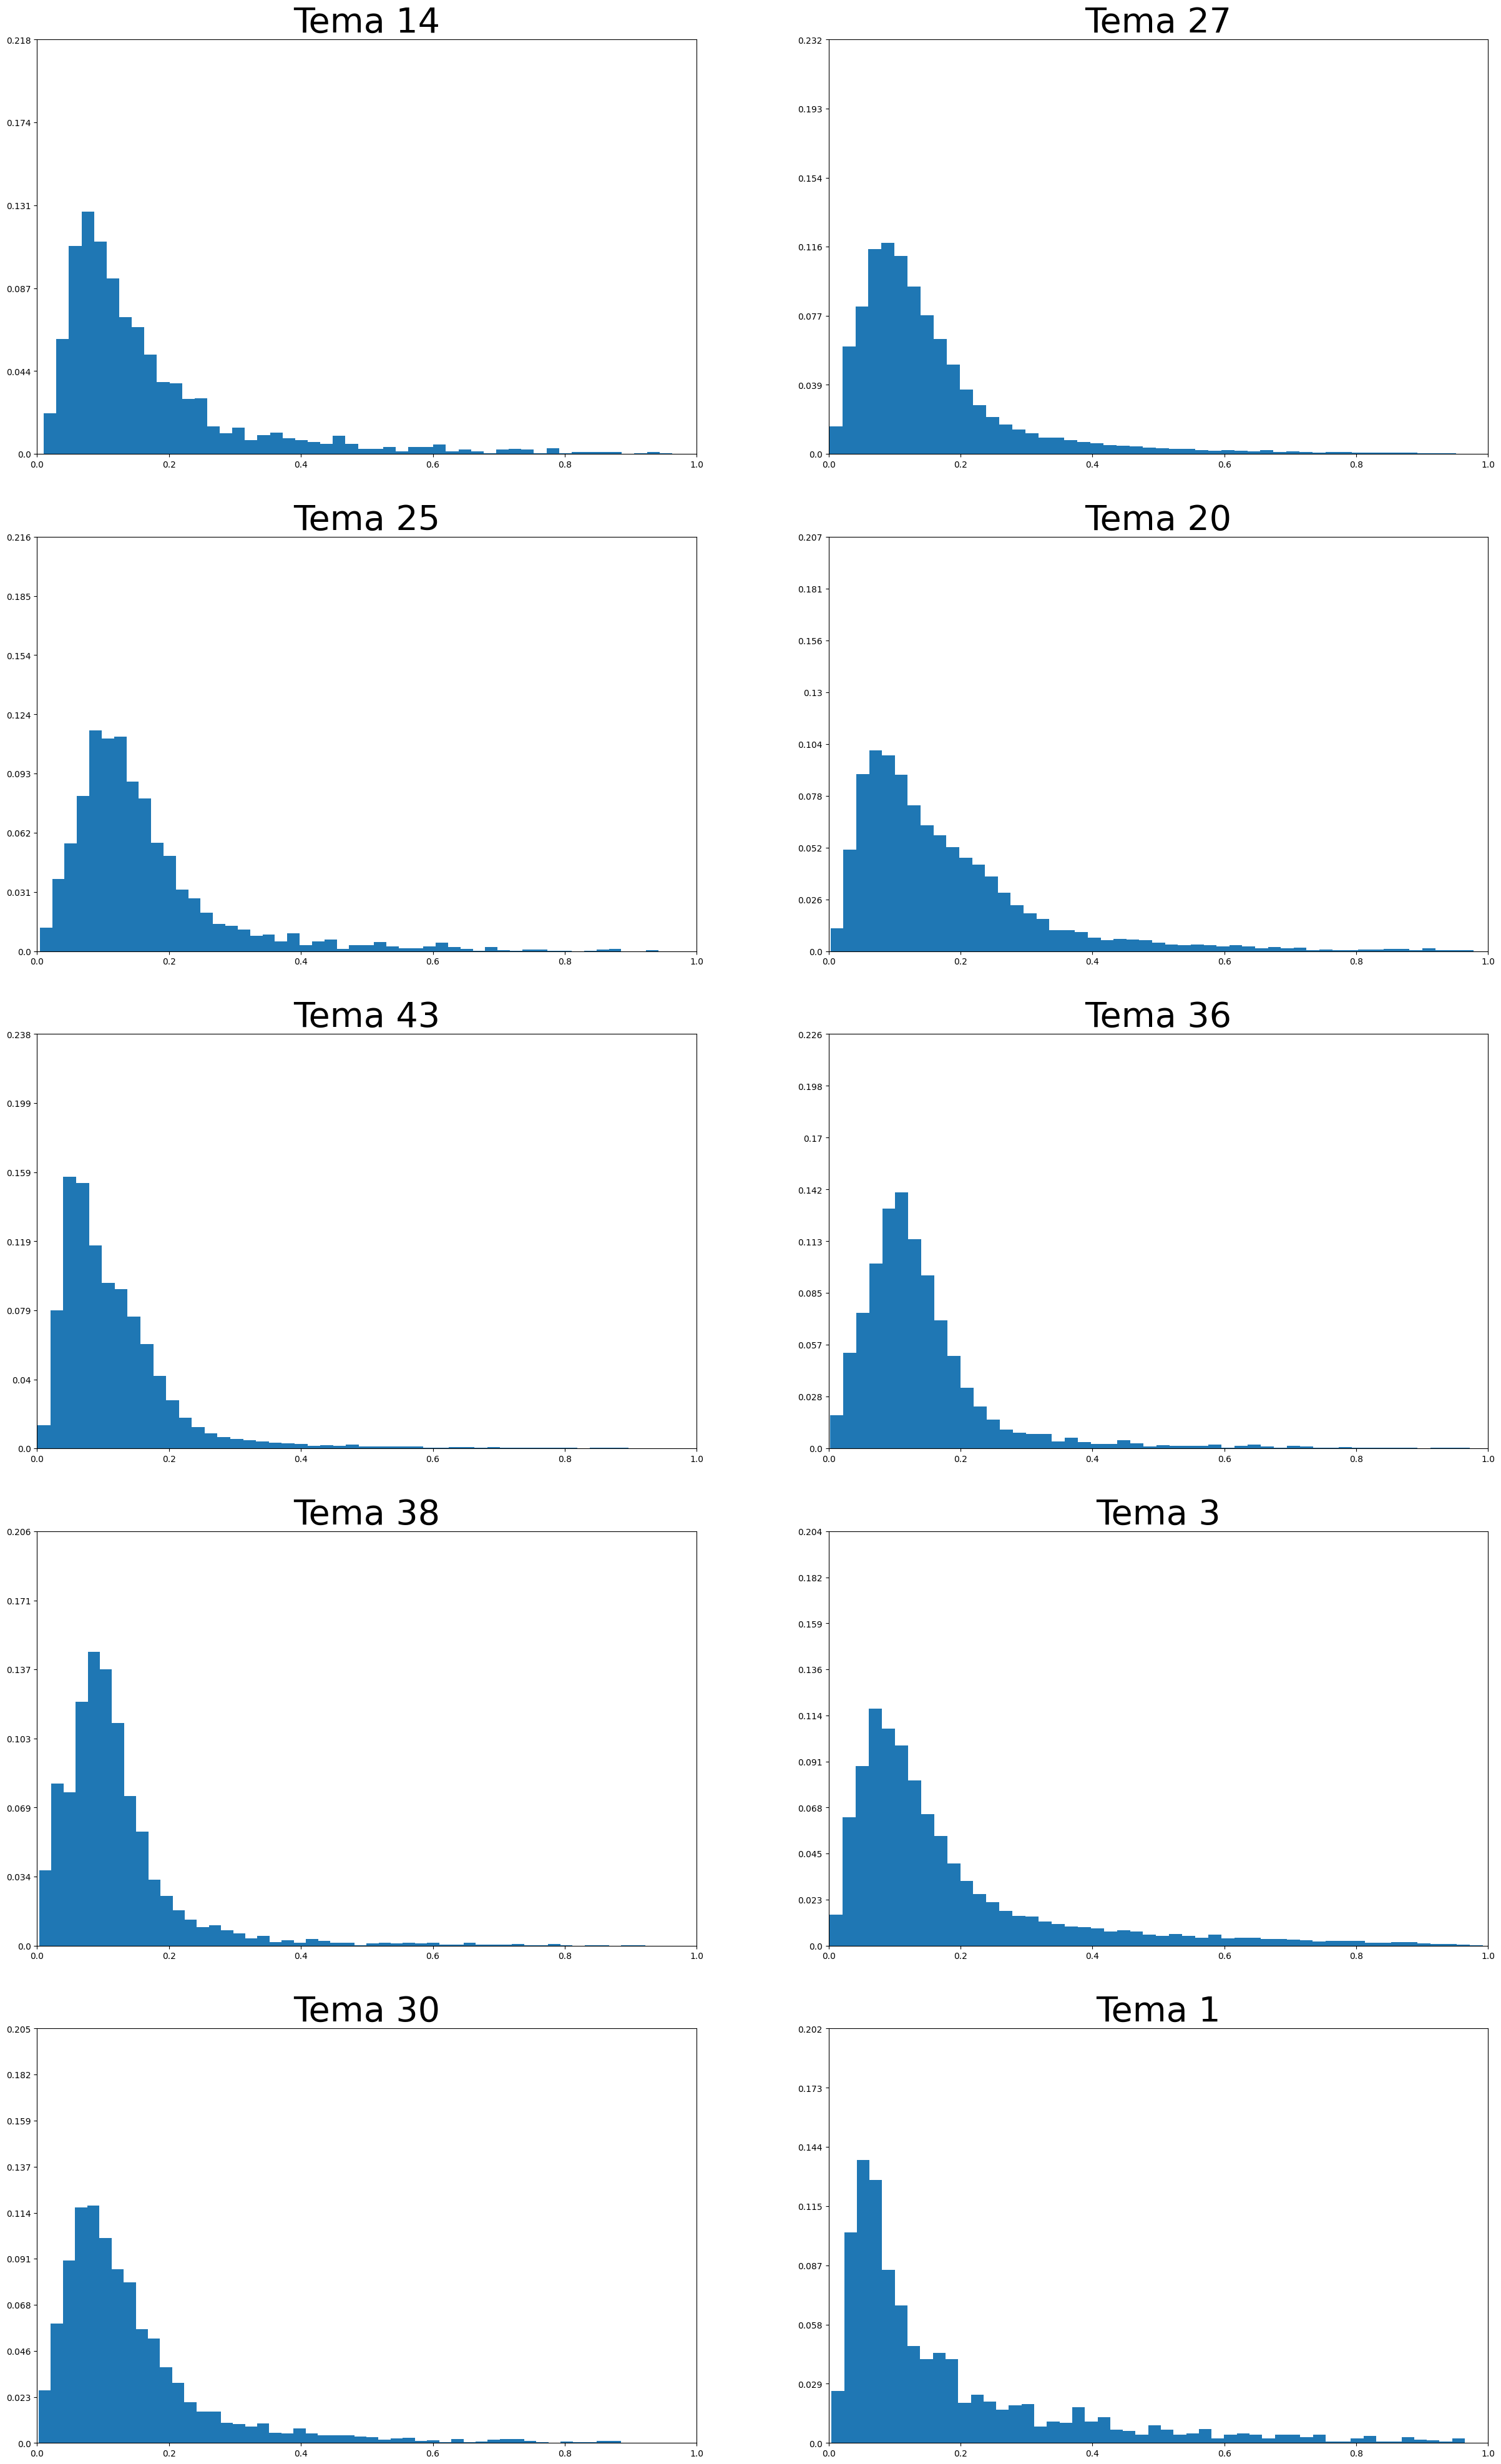

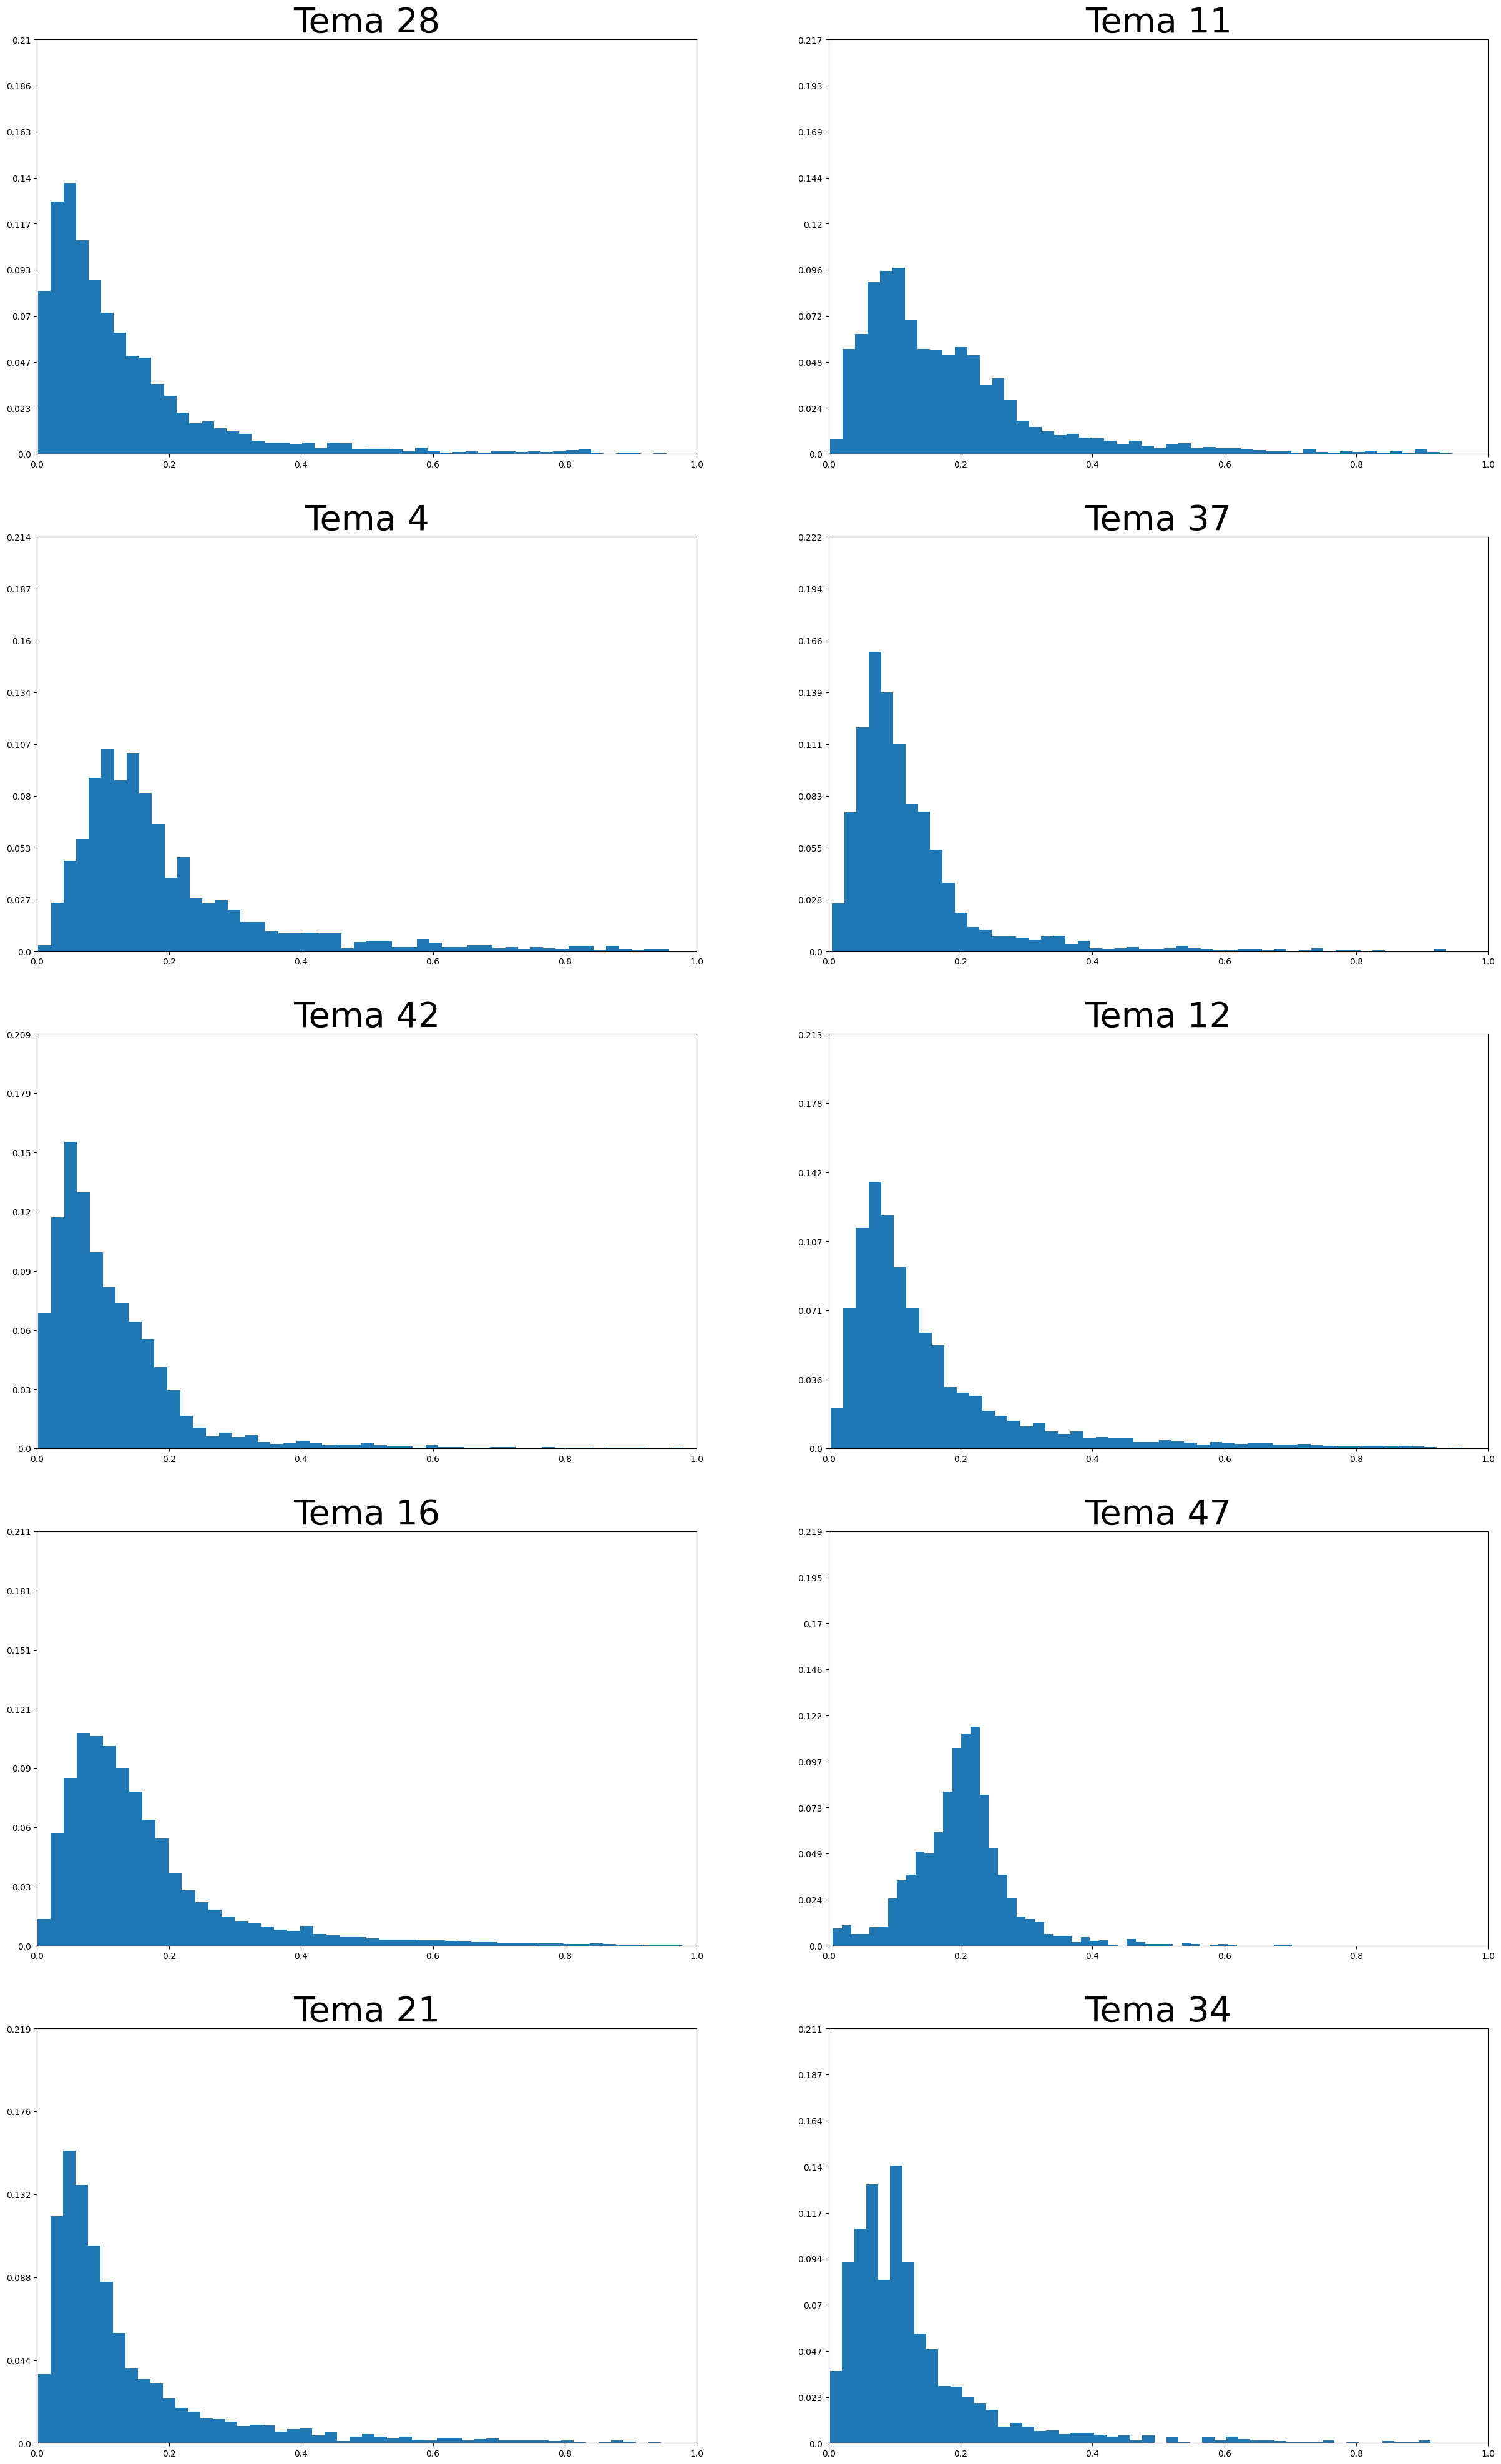

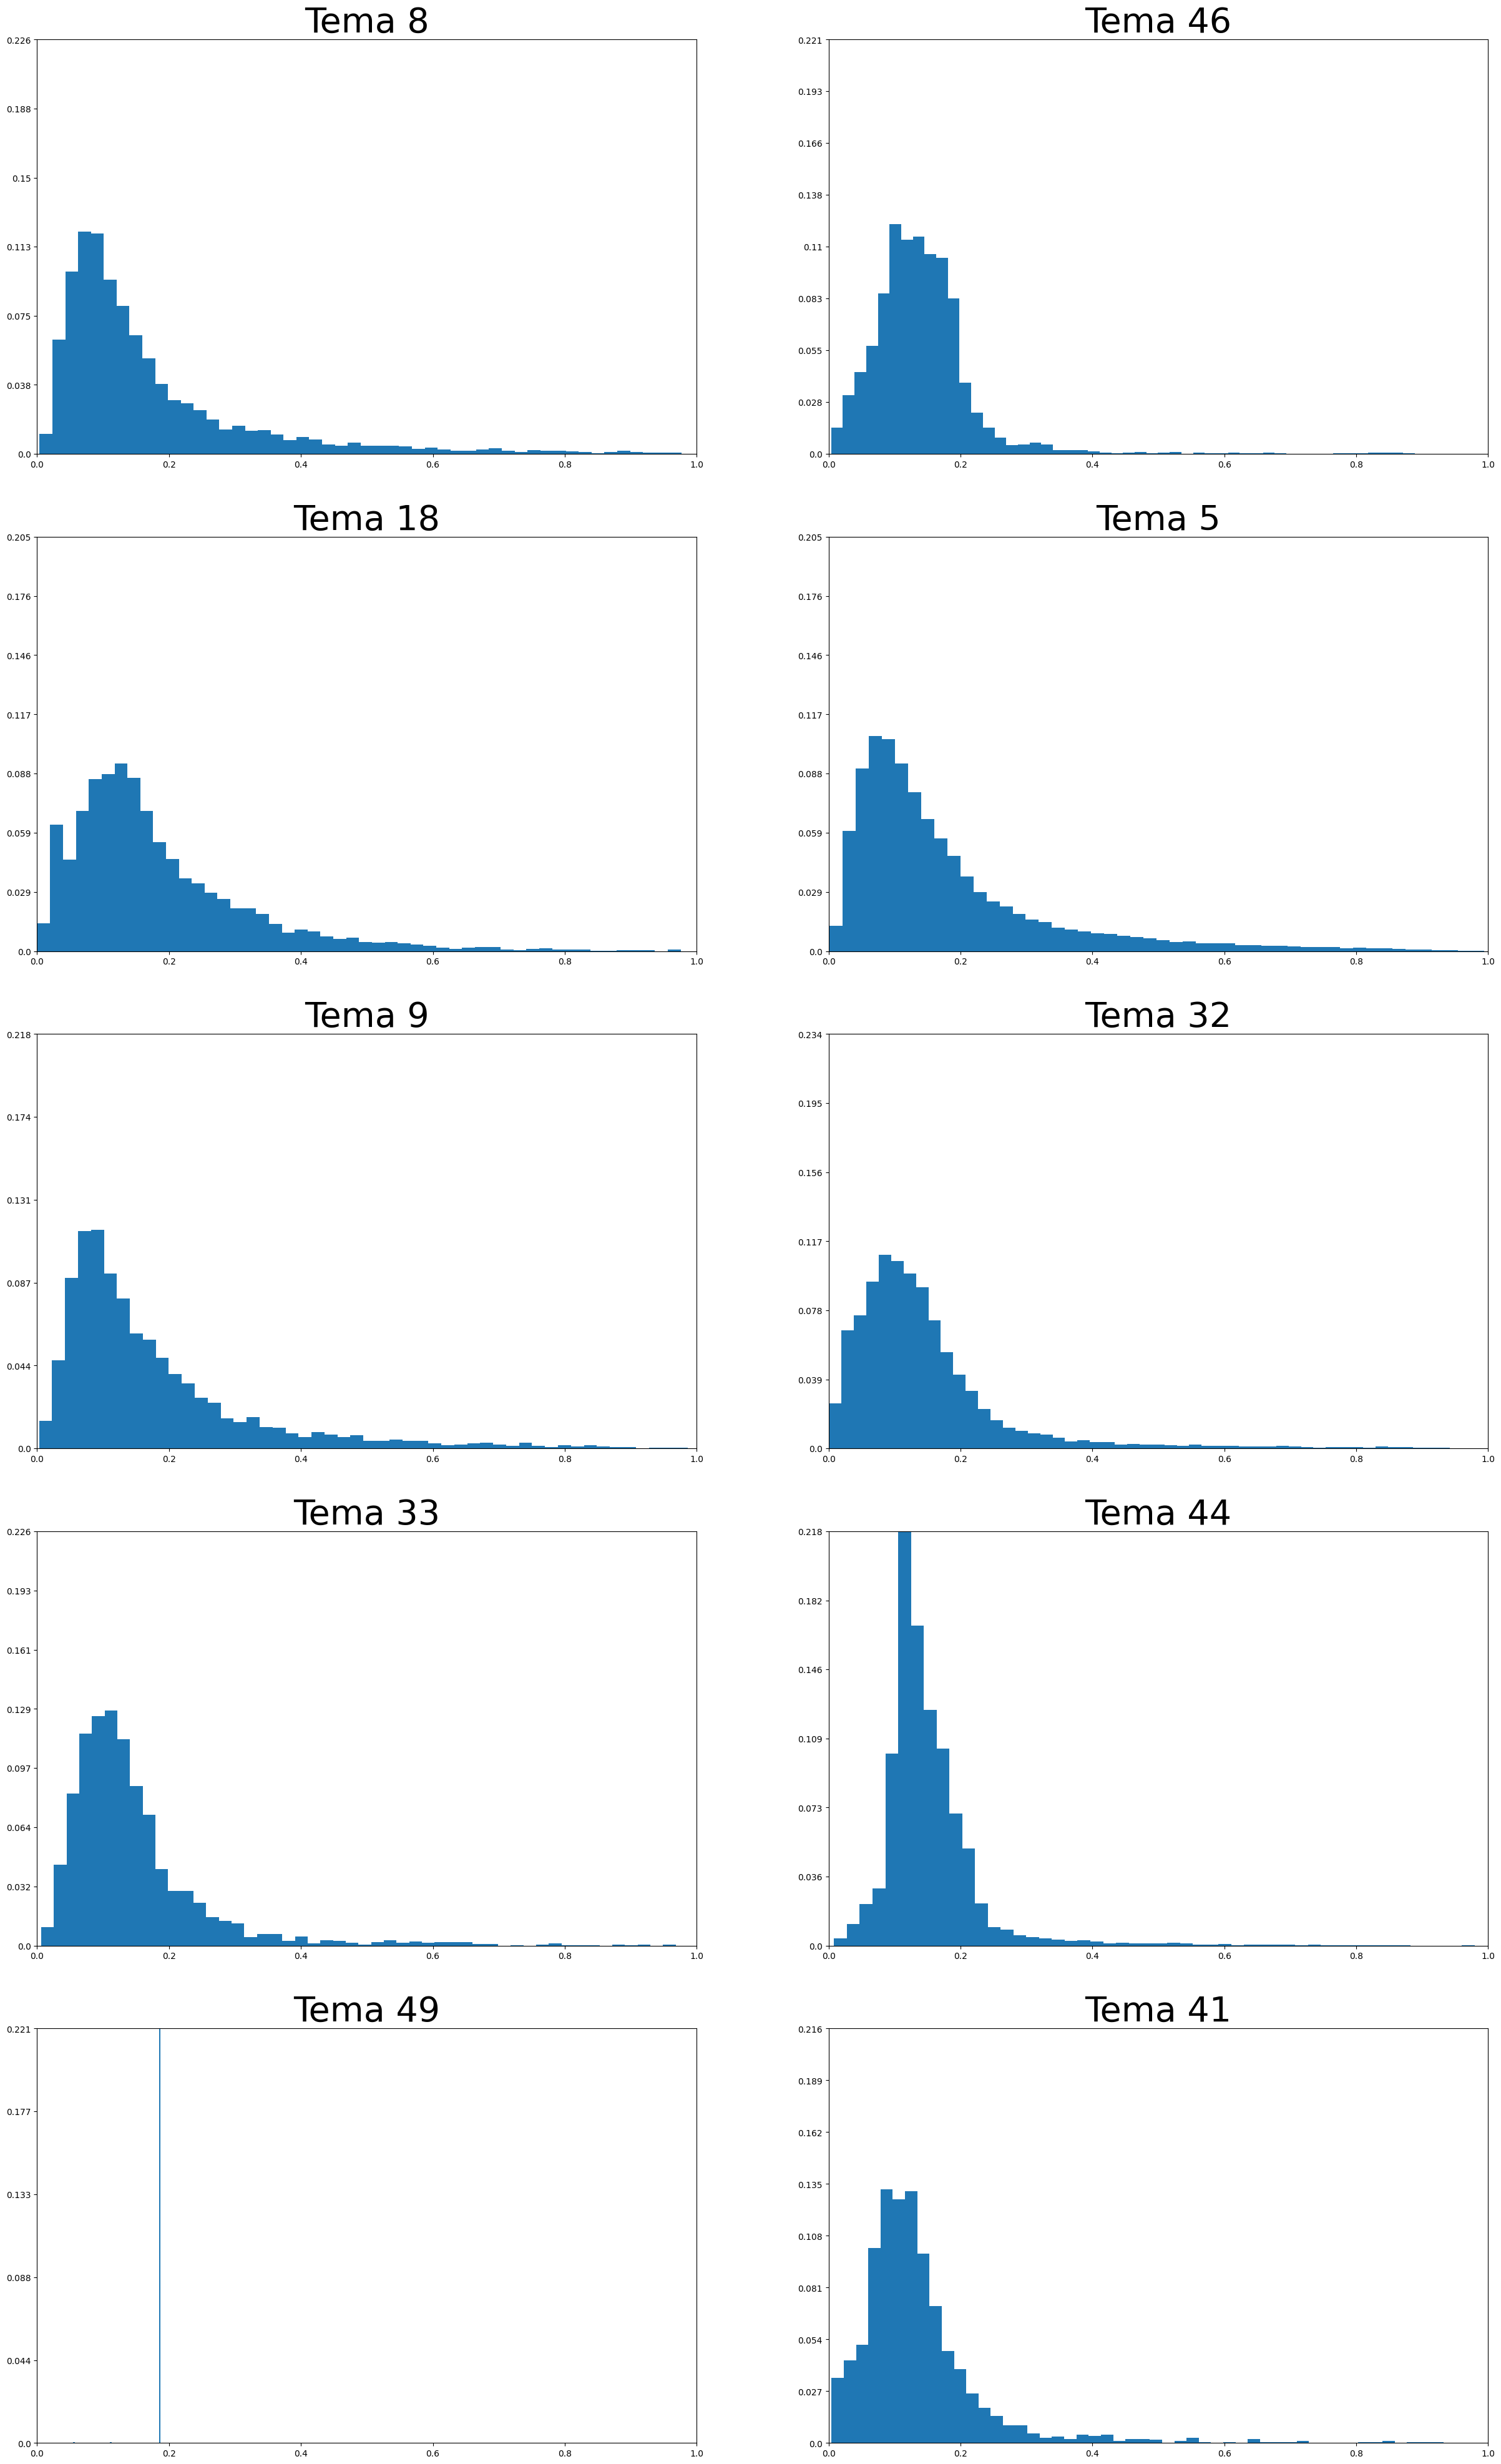

In [4]:
for batch, text in enumerate(['prvih', 'drugih', 'tretjih', 'četrtih', 'petih']):
    plt.subplots(5,2, figsize=(30, 50))
    for i in trange(batch*10, batch*10+10):
        plt.subplot(5, 2, i%10+1)
        plt.xlim(0, 1)
        plt.ylim(0, len(probs_by_topic[s[i]])//5)
        plt.title(f"Tema {s[i]}", fontsize=40.)
        plt.hist(probs_by_topic[s[i]]["prob"], bins=50)
        locs, _ = plt.yticks()
        plt.yticks(locs, np.round(locs/len(probs_by_topic[s[i]]), 3)) # type: ignore
    plt.savefig(f"results-{batch}-{FILE}.pdf", bbox_inches='tight')

# plt.subplots(5,2, figsize=(30, 25))
# plt.suptitle("Distribucije napovedi prilagojenega modela Llama 3, zadnjih 12 tem", fontsize=50.)
# for i in trange(1, 13):
#     plt.subplot(5, 2, i)
#     plt.xlim(0, 1)
#     plt.ylim(0, len(probs_by_topic[s[-i]])//5)
#     plt.title(f"Tema {s[-i]}", fontsize=40.)
#     plt.hist(probs_by_topic[s[-i]]["prob"], bins=50)
#     locs, _ = plt.yticks()
#     plt.yticks(locs, np.round(locs/len(probs_by_topic[s[-i]]), 3)) # type: ignore
# plt.savefig(f"results-bottom9-{FILE}.pdf")


# with open(f"results-{FILE}.txt", "w", encoding="utf-8") as file:
#     for p, w, i in zip(percentage_sarcasm, topic_words, s):
#         file.write(f"Tema {i}: {p}% sarkasticnih clankov, {w}\n")

In [4]:
# ## OLD
# plt.subplots(7,7, figsize=(30, 25))
# plt.suptitle("Distribucije napovedi prilagojenega modela Llama 3 po temah", fontsize=50.)
# for i in trange(1, 50):
#     plt.subplot(7, 7, i)
#     plt.xlim(0, 1)
#     plt.ylim(0, len(probs_by_topic[i])//3)
#     plt.title(f"Tema {i}")
#     plt.hist(probs_by_topic[i]["prob"], bins=25,)
#     locs, _ = plt.yticks()
#     plt.yticks(locs, np.round(locs/len(probs_by_topic[i]), 3)) # type: ignore
# plt.savefig(f"results-{FILE}.pdf")

percentage_sarcasm = list()
topic_words = list()
num_articles = list()
for i, d in enumerate(probs_by_topic):
    num_articles.append(len(d["label"]))
    percentage_sarcasm.append(np.round(100*np.sum(d["label"])/len(d["label"]), 2))
    topic_words.append(" ".join([w for w, _ in topics_map[i-1]]))

s = np.argsort(percentage_sarcasm)[::-1]

percentage_sarcasm = np.array(percentage_sarcasm)[s]
topic_words = np.array(topic_words)[s]
num_articles = np.array(num_articles)[s]
with open(f"results-FINAL.txt", "w", encoding="utf-8") as file:
    for p, w, i, n in zip(percentage_sarcasm, topic_words, s, num_articles):
        print(f"Tema {i} ({n} clankov, {100*n/sum(num_articles):.2f}%): {p}% sarkasticnih clankov, {w}")
        file.write(f"{i} & {n} & {w} & ${p}%$ \\\\\n")

Tema 15 (7118 clankov, 0.79%): 8.91% sarkasticnih clankov, m2 stanovanje nahaja prodamo hiša kuhinjo nepremičnine najemnik kopalnica lokaciji
Tema 48 (1733 clankov, 0.19%): 7.21% sarkasticnih clankov, bitcoin kriptovalut kriptovalute bitcoina neverjetne registracije anonimno kripto forumu postavite
Tema 29 (4315 clankov, 0.48%): 6.95% sarkasticnih clankov, ceste infrastrukturo odseku direkcija odsek križišča cesto kolesarske občina dolžini
Tema 6 (22020 clankov, 2.44%): 6.6% sarkasticnih clankov, stranke sds desus rtv sd stranka volitvah poslancev volitve svoboda
Tema 45 (1871 clankov, 0.21%): 5.83% sarkasticnih clankov, odpadkov odpadki odpadke blata vode čistilne odpadne voda odpadnih čistilno
Tema 2 (68365 clankov, 7.56%): 5.53% sarkasticnih clankov, film pesem pesmi album festival the festivala filma glasbe ljubezen
Tema 19 (5999 clankov, 0.66%): 5.45% sarkasticnih clankov, stanovanj občina občine gradnjo stanovanja župan evrov občini najemnih svetniki
Tema 35 (3437 clankov, 0.38%)